# Quant Insights


In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import yfinance as yf
from scipy.stats import norm
import time
import matplotlib.pyplot as plt


In [2]:
# Define your strategy and utility functions
def mean_reversion_strategy(df, window=20, std_dev=2):
    df['mean'] = df['Close'].rolling(window=window).mean()
    df['std'] = df['Close'].rolling(window=window).std()
    df['z_score'] = (df['Close'] - df['mean']) / df['std']
    
    df['upper_band'] = df['mean'] + (std_dev * df['std'])
    df['lower_band'] = df['mean'] - (std_dev * df['std'])

    df['signal'] = 0
    df.loc[df['z_score'] < -std_dev, 'signal'] = 1
    df.loc[df['z_score'] > std_dev, 'signal'] = -1
    return df

def gbm_simulation(S0, T, mu, sigma, dt=1/252):
    N = int(T / dt)
    t = np.linspace(0, T, N)
    W = np.random.standard_normal(size=N)
    W = np.cumsum(W) * np.sqrt(dt)
    X = (mu - 0.5 * sigma**2) * t + sigma * W
    S = S0 * np.exp(X)
    return S

def execute_trade(signal, symbol, qty=25):
    if signal == 1:
        print(f"Buy order for {symbol}")
    elif signal == -1:
        print(f"Sell order for {symbol}")

def fetch_historical_data(ticker, start_date, end_date, interval):
    data = yf.download(ticker, period='max')
    return data

def fetch_real_time_data(ticker):
    data = yf.download(ticker, period='1d', interval='1m')
    return data

def update_data_frame(df, new_data):
    return pd.concat([df, new_data]).drop_duplicates().reset_index(drop=True)

def calculate_kelly_criterion(win_prob, win_loss_ratio):
    """
    Calculate Kelly criterion.
    win_prob: Probability of winning
    win_loss_ratio: Ratio of average win to average loss
    """
    return win_prob - (1 - win_prob) / win_loss_ratio

def bollinger_bands(prices, period=20, num_std=2):
    """
    Calculates Bollinger Bands.
    
    :param prices: A pandas Series of prices
    :param period: The lookback period for the moving average
    :param num_std: The number of standard deviations for the bands
    :return: A pandas DataFrame with the moving average, upper band, and lower band
    """
    rolling_mean = prices.rolling(window=period).mean()
    rolling_std = prices.rolling(window=period).std()
    
    upper_band = rolling_mean + (rolling_std * num_std)
    lower_band = rolling_mean - (rolling_std * num_std)
    
    return pd.DataFrame({'Middle Band': rolling_mean, 'Upper Band': upper_band, 'Lower Band': lower_band})




[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['SBIN.NS']: ConnectionError(MaxRetryError('HTTPSConnectionPool(host=\'query1.finance.yahoo.com\', port=443): Max retries exceeded with url: /v1/test/getcrumb (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000025E2329FF10>: Failed to resolve \'query1.finance.yahoo.com\' ([Errno 11001] getaddrinfo failed)"))'))


TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

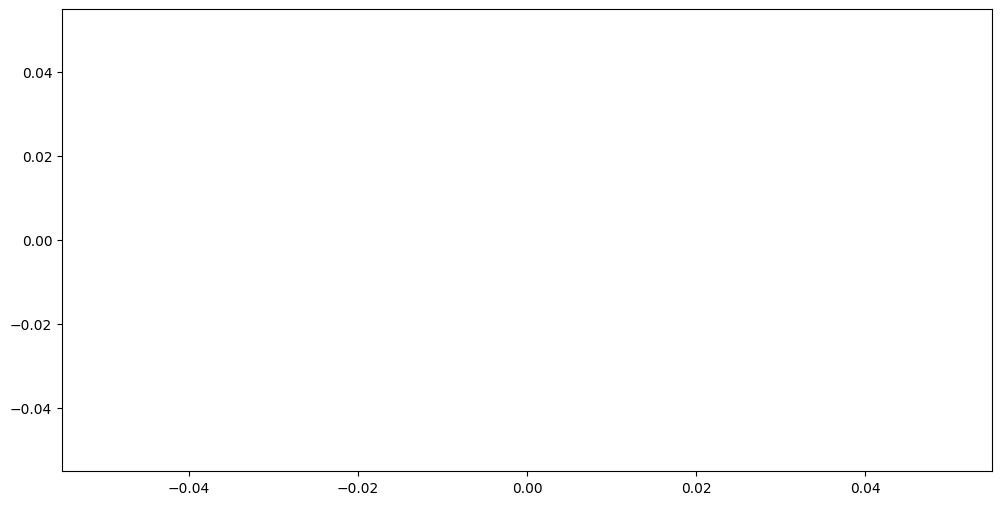

In [3]:
# Usage for fetching historical data
symbol = 'SBIN.NS'
start_date = '2024-04-30'
end_date = '2024-06-28'
interval = '5m'

# Fetch historical data
historical_data = fetch_historical_data(symbol, start_date, end_date, interval)
real_time_df = mean_reversion_strategy(historical_data)

# Plotting the initial historical data
plt.figure(figsize=(12,6))
plt.plot(real_time_df.index, real_time_df['Close'], label='Close Price')
plt.plot(real_time_df.index, real_time_df['mean'], label='Mean')
plt.fill_between(real_time_df.index, real_time_df['lower_band'], real_time_df['upper_band'], color='gray', alpha=0.2, label='Bollinger Bands')
plt.legend()
plt.show()

In [ ]:
def plot_signals(df):
    plt.figure(figsize=(12,6))
    plt.plot(df.index, df['Close'], label='Close Price')
    plt.plot(df.index, df['mean'], label='Mean')
    plt.fill_between(df.index, df['lower_band'], df['upper_band'], color='gray', alpha=0.2, label='Bollinger Bands')
    buy_signals = df[df['signal'] == 1]
    sell_signals = df[df['signal'] == -1]
    plt.plot(buy_signals.index, buy_signals['Close'], '^', markersize=10, color='g', lw=0, label='Buy Signal')
    plt.plot(sell_signals.index, sell_signals['Close'], 'v', markersize=10, color='r', lw=0, label='Sell Signal')
    plt.legend()
    plt.show()

# Plotting the initial historical data with signals
plot_signals(real_time_df)

# Calculate historical performance metrics for Kelly criterion
historical_df = mean_reversion_strategy(historical_data)
historical_df['returns'] = historical_df['Close'].pct_change()
historical_df['strategy_returns'] = historical_df['signal'].shift(1) * historical_df['returns']

win_prob = (historical_df['strategy_returns'] > 0).mean()
win_loss_ratio = historical_df['strategy_returns'][historical_df['strategy_returns'] > 0].mean() / -historical_df['strategy_returns'][historical_df['strategy_returns'] < 0].mean()

kelly_fraction = calculate_kelly_criterion(win_prob, win_loss_ratio)
print(f"Kelly Fraction: {kelly_fraction:.2f}")

# Initialize capital
capital = 100000  # example initial capital

# Initialize trade log
trade_log = []

# Main loop for real-time trading
while True:
    try:
        # Fetch real-time data
        new_data = fetch_real_time_data(symbol)
        if not new_data.empty:
            real_time_df = update_data_frame(real_time_df, new_data)
            real_time_df = mean_reversion_strategy(real_time_df)
            signal = real_time_df['signal'].iloc[-1]
            
            # Simulate future prices using GBM
            S0 = real_time_df['Close'].iloc[-1]
            T = 1/252  # 1 day
            mu = 0.001  # example expected return
            sigma = 0.02  # example volatility
            simulated_prices = gbm_simulation(S0, T, mu, sigma)
            expected_price = simulated_prices[-1]
            
            # Add GBM-based signal logic
            if expected_price > real_time_df['upper_band'].iloc[-1]:
                signal = -1
            elif expected_price < real_time_df['lower_band'].iloc[-1]:
                signal = 1
            
            # Determine position size based on Kelly criterion
            position_size = int(capital * kelly_fraction)
            
            # Log trade
            trade_log.append({
                'time': pd.Timestamp.now(),
                'symbol': symbol,
                'signal': 'Buy' if signal == 1 else 'Sell',
                'quantity': position_size,
                'price': S0
            })
            
            execute_trade(signal, symbol, qty=position_size)
        
        # Plot updated signals
        plot_signals(real_time_df)
        
        # Wait for 1 minute before the next iteration
        time.sleep(10)
    
    except KeyboardInterrupt:
        print("Trading stopped.")
        break
    except Exception as e:
        print(f"Error: {e}")
        continue

# Convert trade log to DataFrame and save to CSV
trade_log_df = pd.DataFrame(trade_log)
trade_log_df.to_csv('trade_log.csv', index=False)
print(trade_log_df)